# Chapter 5.1 of thesis

**Data:** the 1700-1800 selection (109 and 108 proxy records)
- main-text: Median proxy record and model comparison:
        - multi-model medan
        - iqr of modeled values
        - model vs record median, colors
- appendix: single model plots, including the correlation. Starting with that plot

**Style:** 
- More vertical than horizontal plots (e,g. 5x2), because of the paper size
- save figure outside of function (adjust it first, and when its fine use it)

In [11]:
import sys
sys.path.append('/home/mchoblet/paleoda')
import xarray as xr
import numpy as np

from types import SimpleNamespace

In [12]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import cartopy.crs as ccrs
from scipy.stats import linregress
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature  
from matplotlib.offsetbox import AnchoredText    

import warnings

import psm_pseudoproxy
import utils 
import evaluation
import copy

from scipy import stats
import cartopy.crs
from seaborn import regplot
from scipy.stats import iqr
from matplotlib import ticker

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
#redux version of config dictionary

cfg={
'vp':{
'd18O':'/home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc',
'tsurf': '/home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc',
'evap': '/home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc',
'slp': None,
},
'avg':None,
'oro': '/home/mchoblet/paleoda/data/orographies/echam_oro.nc',
'obsdata':['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1700_1800.nc'],
'only_regional_proxies':False,
'regional_bounds':False,
'obs_var':[['d18O','d18O_precision'],['d18O','d18O_precision']], #name of variables and uncertainties in proxy_db files
'proxy_error': [0.1,0.1], #irrelevant for PPE
'time_scales': ['median','median'],
'proxy_time':['0000','2015'],
'time': ['0000','2015'],
'resample': True,
'resample_mode': 'nearest',
'mask': 3, 
###MULTI-TIMESCALE
#'timescales':[1,5,10,20], #list of timescales (have to be true divisors of longest timescale (block size)) Timescale 1 always required! 
'timescales':[1,3,6,12,24], #list of timescales (have to be true divisors of longest timescale (block size)) Timescale 1 always required! 
'reuse': True,
'ppe': {'use':False},
'check_nan': False,
'reconstruct':['tsurf','d18O','prec']
}


cfg['psm']=['speleo','icecore']
cfg['interpol']=None
cfg['var_psm']=['d18O','d18O'] #only relevant if psm=None  
cfg['speleo']={
    'weighting':'inf', #None(pure d18O) / prec (d180 prec weighted)/ inf (d18O prec-evap weighted)
    'height': True, #height correction: True requires orography of model + proxy_db must have a coordinate 'elev'. Lapse rate assumed -0.28 for isotopes and -0.65 for temperature
    'fractionation':True, #requires tsurf (in 'vp')
    'fractionation_temp': 'regular', #'mean'
    'filter': True, #True: convolution of yearly means with 2.5 year transit time, or float: transit time
    't_time': 2.5, #if filter equal true, use this as a transit time
}
cfg['icecore']={
    'weighting':'prec', #None(pure d18O) / prec (d180 prec weighted)
    'height': True, #height correction: True requires orography of model and 'elev' coordinate for proxy_db. Requires that proxy_db has a coordinate 'lapse rate' (e.g. i attributed -0.15 to non polar porxies and -0.28 to polar ones (per 100m)
    'filter': True, #If True the PSM-function from PRYSM which takes into account diffusion is applied. 
}

In [14]:
paths={
'iCESM':{'d18O':'/home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc',
       },
'isoGSM':{'d18O':'/home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc',
       },    
'Echam':{'d18O':'/home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc',
       },
'GISS':{'d18O':'/home/mchoblet/paleoda/data/model_data/GISS_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/GISS_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/GISS_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/GISS_tsurf_850_1849.nc',
'slp': '/home/mchoblet/paleoda/data/model_data/GISS_slp_850_1849.nc',
       },
'iHadCM3':{'d18O':'/home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/iHADCM3_prec_801_1952.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/iHADCM3_tsurf_801_1952.nc',
'slp':'/home/mchoblet/paleoda/data/model_data/iHADCM3_slp_801_1952.nc',
       }
} 

#I checked once again that nothing with the longitudes is wrong (all go from 0 to 360)
oro_dic={
'iCESM':'/home/mchoblet/paleoda/data/orographies/icesm_oro.nc',
    'isoGSM':'/home/mchoblet/paleoda/data/orographies/ccsm_oro.nc',
'Echam': '/home/mchoblet/paleoda/data/orographies/echam_oro.nc',
'GISS':'/home/mchoblet/paleoda/data/orographies/giss_oro.nc',
'iHadCM3':'/home/mchoblet/paleoda/data/orographies/hadcm3_oro.nc',
}

In [25]:
def map_plot_vert(pp_y,HX_full,names=list(oro_dic.keys()),title='Mean value comparison for SISAL',
                  loc='lower right',vmin=-10,vmax=10,xfac=1,yfac=1,savefig=None,minval=-40):
    """
    Plot of mean value difference of locations on the map and the mean value comparison to the right.
    This is quite manual, but the only way to achieve plotting them easily side by side.
    https://stackoverflow.com/questions/61433850/combination-of-normal-and-cartopy-subplots-within-the-same-figure
    """
    sns.set_theme(style="white")
    
    #fig, axs = plt.subplots(nrows=1,ncols=len(HX_full),figsize=(40,4),sharex=True,subplot_kw={'projection':ccrs.Robinson()})
    #fig, axs = plt.subplots(nrows=5,ncols=1,figsize=(30,20),sharex=True,subplot_kw={'projection':ccrs.PlateCarree()})
    fac=1.2
    fig = plt.figure(figsize=(int(12*fac),int(18*fac)))
    gs = fig.add_gridspec(5, 2)
    fig.suptitle(title,fontsize=40)
    colors=np.concatenate(([(0,0,0)],sns.color_palette(palette='colorblind', n_colors=5)))

    cm=mpl.cm.get_cmap('bwr')
    mean_proxy=pp_y.median('time')
    mpl.rcParams.update({'font.size': 22})

    for x,pp in enumerate(HX_full):
            vmin=vmin
            vmax=vmax
            ax1 = fig.add_subplot(gs[x,0], projection=ccrs.PlateCarree())
            ax1.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
            ax1.coastlines(resolution='auto', color='k')
            ax1.gridlines(color='lightgrey', linestyle='--', alpha=0.8,draw_labels=False,)
        
            # add coastlines
            #axs[x].add_feature(cfeature.COASTLINE)
            ax1.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
            
            mean_prior=pp.median(dim='time')#.sel(site=mean_proxy.site.values)
            p1=ax1.scatter(mean_proxy.lon,mean_proxy.lat,c=(mean_prior-mean_proxy),s=150, cmap=cm, transform=ccrs.PlateCarree(), edgecolors='black',vmin=vmin,vmax=vmax)
            ax1.set_title(names[x],fontsize=30)     
            
            oro=xr.open_dataset(oro_dic[names[x]])['oro']
            oro=psm_pseudoproxy.obs_from_model(oro,lat=pp.lat.values,lon=pp.lon.values,interpol=None)

            elev=pp.elev
            #vmin=-3000
            #vmax=3000
            z=(elev-oro)

            mean_prior=pp.median(dim='time',skipna=True)#.sel(site=mean_proxy.site.values)            
            #if x==4:
            #    import pdb
            #    pdb.set_trace()
            slope, intercept, r, p, std_err = stats.linregress(mean_proxy,mean_prior)
            
            #confidence intervals
            slope_0=slope-1.96*std_err
            slope_2=slope+1.96*std_err
            
            def myfunc(x):
                return slope * x + intercept

            mymodel = list(map(myfunc, mean_proxy.values))            
            
            string= str(np.round(r,decimals=2))+',(' + str(np.round(slope,decimals=2)) +','+str(np.round(intercept,decimals=2)) + ')'+''         
            ax2 = fig.add_subplot(gs[x,1])
            #ax2.plot(mean_proxy, mymodel,color='blue',ls='-',label=string)
            
            #plot regression lines with confidence intervals, cf=95%. Super easy with seaborn
            #unfortunately seaborn regplot does not return any statistics :O
            #p=axs[x].scatter(mean_proxy,mean_prior,c=z,s=150,cmap=cm, edgecolors='black',vmin=vmin,vmax=vmax)
            p=ax2.scatter(np.array(mean_proxy.values),mean_prior.values,c=z,s=150,cmap='BrBG', edgecolors='black',vmin=-3000,vmax=3000)#,vmin=vmin,vmax=vmax)
        
            #regplot(x=np.array(mean_proxy.values),y=mean_prior.values,ci=95,color='blue',marker=None,ax=ax2,scatter_kws={'color':'lightblue','vmin':-3000,'vmax':3000})
            regplot(x=np.array(mean_proxy.values),y=mean_prior.values,ci=95,marker=None,ax=ax2,scatter_kws={'color':'lightblue','marker':None,'s':0},line_kws={'color':'peru'})

            ax2.set_xlabel('',fontsize=30)
            ax2.set_ylabel('Model [‰]',fontsize=26)
            ax2.set_xlim((minval,1))
            ax2.set_ylim((minval,1))
            #set number of ticks
            ax2.locator_params(axis='y', nbins=5)
            ax2.locator_params(axis='x', nbins=3)
            
            ax2.plot(np.arange(minval,1,1),np.arange(minval,1,1),color='grey',ls='--')
            ax2.grid()

            ax2.yaxis.tick_right()
            #if x==2:
                #ax2.set_ylabel('Simulation after PSM',fontsize=30)
            #plt.gca().set_ylabel('Simulation', rotation=270, va="bottom",fontsize=30,labelpad=35)
            ax2.yaxis.set_label_position("right")
                #axs[x].yaxis.set_ticklabels([-20,-15,-10,-5,0])
            #if x!=4:
            #    ax2.set_xticks([])
            ax2.set_xticks(np.linspace(minval,0,5))
            #else:
                #axs[x].set_ylabel('',fontsize=30)
                #axs[x].set_yticks([])
                #ax2.yaxis.set_ticklabels([])

            #textbox with regression parameter
            box_text = '\n'.join((
            r'Corr: %.2f' % r,
            r'Slope: %.2f [%.2f,%.2f]' % (slope,slope_0,slope_2),
            r'Intercept: %.2f' % intercept,
            ))

            text_box = AnchoredText(box_text, frameon=True, loc=loc, pad=0.5, prop=dict(fontsize=14))
            plt.setp(text_box.patch, facecolor='white', alpha=1)
            ax2.add_artist(text_box)

            ax2.tick_params(axis='both', which='major', labelsize=20)
            ax2.tick_params(axis='both', which='minor', labelsize=20)
            #axs[0].set_xlabel('Common x-label')

            #fig.text(0.5, -0.05, 'Proxies', ha='center',fontsize=30)

    ax2.set_xlabel('Record [‰]',fontsize=26)
    #fig.subplots_adjust(wspace=0.1)
    plt.tight_layout() 
    """
    plt.legend(fontsize=18,loc='center left')
    plt.title(title,fontsize=30)
    # y-axis
    ax.text(-0.08, 0.5, 'Latitude', va='bottom', ha='center',
            rotation='vertical', rotation_mode='anchor',
            transform=ax.transAxes,fontsize=25)
    # x-axis
    ax.text(0.5, -0.12, 'Longitude', va='bottom', ha='center',
            rotation='horizontal', rotation_mode='anchor',
            transform=ax.transAxes,fontsize=25)
    
    if savefig is not None:
        plt.savefig('/home/ldap-server/draco/notebooks/paleoda/paleoda/plots/locations.pdf', format='pdf',bbox_inches='tight')
    """

    from matplotlib import ticker
    
    #colormap for left plot
    p0 = ax1.get_position().get_points().flatten()
    ax_cbar1 = fig.add_axes([p0[0], p0[1]-0.05, (p0[2]-p0[0]), 0.01])
    cb=fig.colorbar(p1, cax=ax_cbar1, orientation='horizontal',cmap=cm)
    cb.ax.tick_params(labelsize=20)
    tick_locator = ticker.MaxNLocator(nbins=3)
    cb.locator = tick_locator
    cb.update_ticks()
    cb.set_label(r'$\overline{\mathrm{Model}}$-$\overline{\mathrm{Record}}$ [‰]',fontsize=30)
    
    #colormap for right plot
    p0 = ax2.get_position().get_points().flatten()
    ax_cbar2 = fig.add_axes([p0[0], p0[1]-0.05, (p0[2]-p0[0]), 0.01])
    cb=fig.colorbar(p, cax=ax_cbar2, orientation='horizontal',cmap='BrBG')
    cb.ax.tick_params(labelsize=20)
    tick_locator = ticker.MaxNLocator(nbins=3)
    cb.locator = tick_locator
    cb.update_ticks()
    cb.set_label('Model height - real height [m]',fontsize=30)
    
    if savefig is not None:
        if savefig==True:
            plt.savefig('/home/mchoblet/paleoda/results/plots/mean_plot_map_sisal.pdf', format='pdf',bbox_inches='tight')
        else:
            plt.savefig(savefig, format='pdf',bbox_inches='tight')
    
    return fig

In [16]:
#proxy databases and errors list of DAs, final time given by c.proxy_time.
#site has 0.+..., 1.+... to mark the distinct proxy dbs
c=SimpleNamespace(**cfg)
pp_y_all,pp_r_all=utils.proxy_load(c)

>>>>>LOADING PROXY DATA


In [17]:
#generate proxy system model filtered data.
sisal_ = []
iso2k_ = []
prior_dict={}

#for a faster generation leave out the the ice core filter
cfg['icecore']['filter']=False
for i,p in paths.items():
    cfg['check_nan']=True
    cfg['vp'] = p
    cfg['oro'] = oro_dic[i]
    cfg['interpol']=None
    c=SimpleNamespace(**cfg)
    prior, attributes, prior_raw=utils.prior_preparation(c)
    prior_dict[i]=prior
    HXfull_all=utils.psm_apply(c,prior,prior_raw, pp_y_all)
    sisal_.append(HXfull_all[0])
    iso2k_.append(HXfull_all[1])

Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
Checking prior for nans
Checking prior for nans
Checking prior for nans
>>>>>>>>>>>>>APPLYING HEIGHT CORRECTION
>>>>>>>>>>>>>APPLYING KARST FILTER
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING PREC WEIGHTING
Checking prior for nans
>>>>>>>>>>>>>APPLYING HEIGHT CORRECTION
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average


In [18]:
#these lists were created with the speleothem and the ice core filter
sisal_nofilt=copy.deepcopy(sisal_)
iso2k_nofilt=copy.deepcopy(iso2k_)

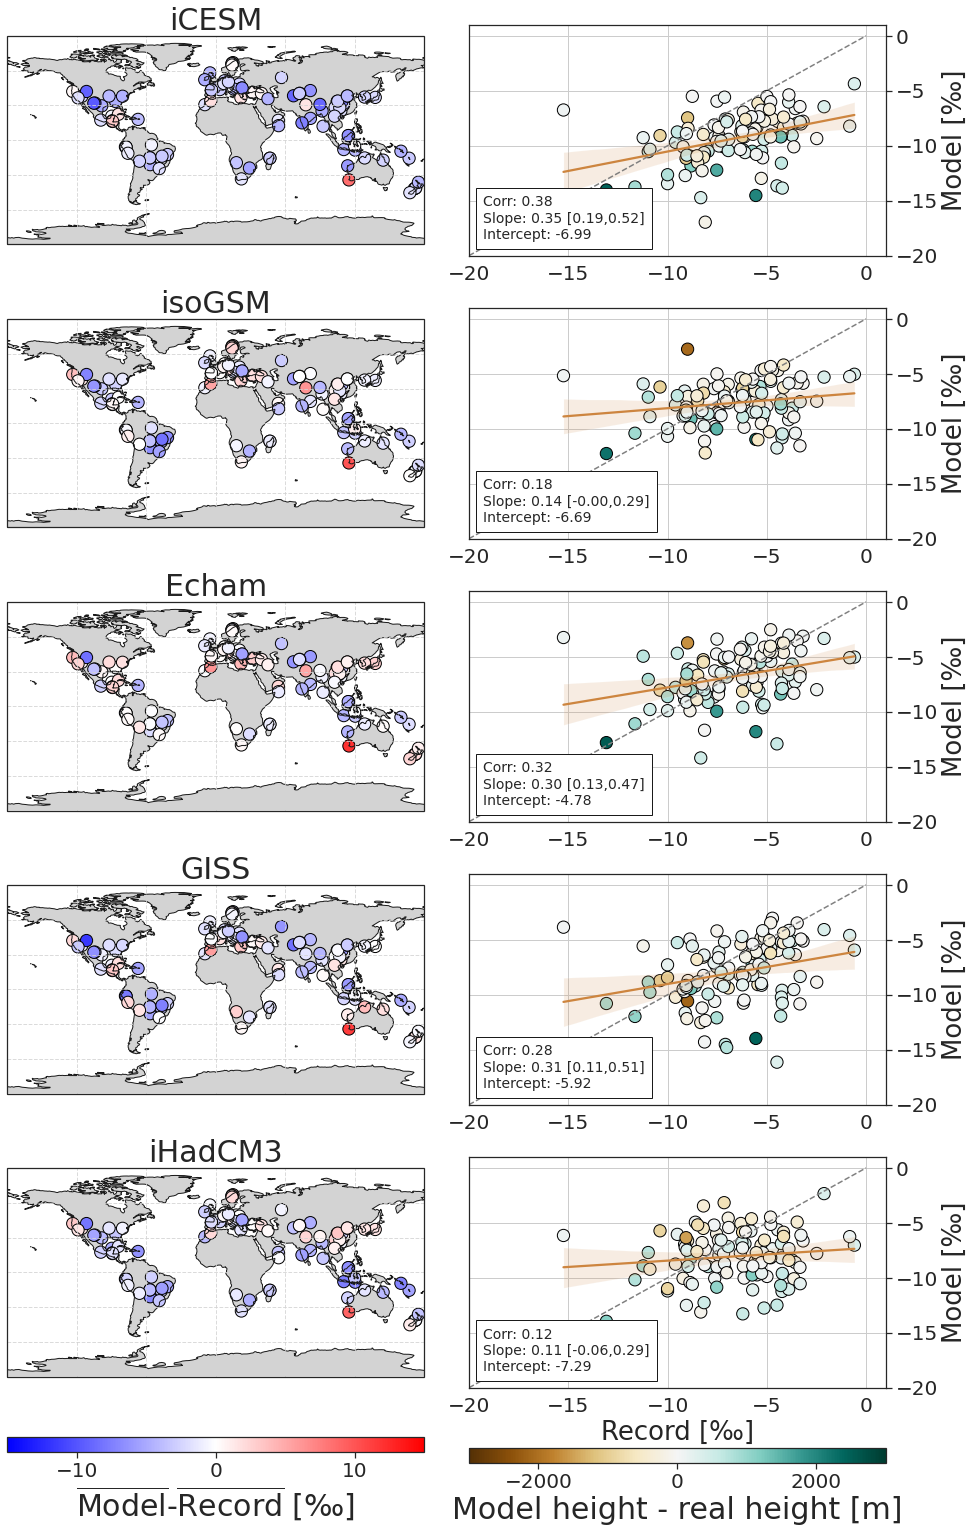

In [26]:
sisal_plot=map_plot_vert(pp_y_all[0],sisal_,names=list(oro_dic.keys()),title='',loc='lower left',vmin=-15,vmax=15,minval=-20,savefig=None)

In [27]:
sisal_plot.savefig('/home/mchoblet/plots_thesis/5_1/sisal_appendix.pdf', dpi='figure', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )



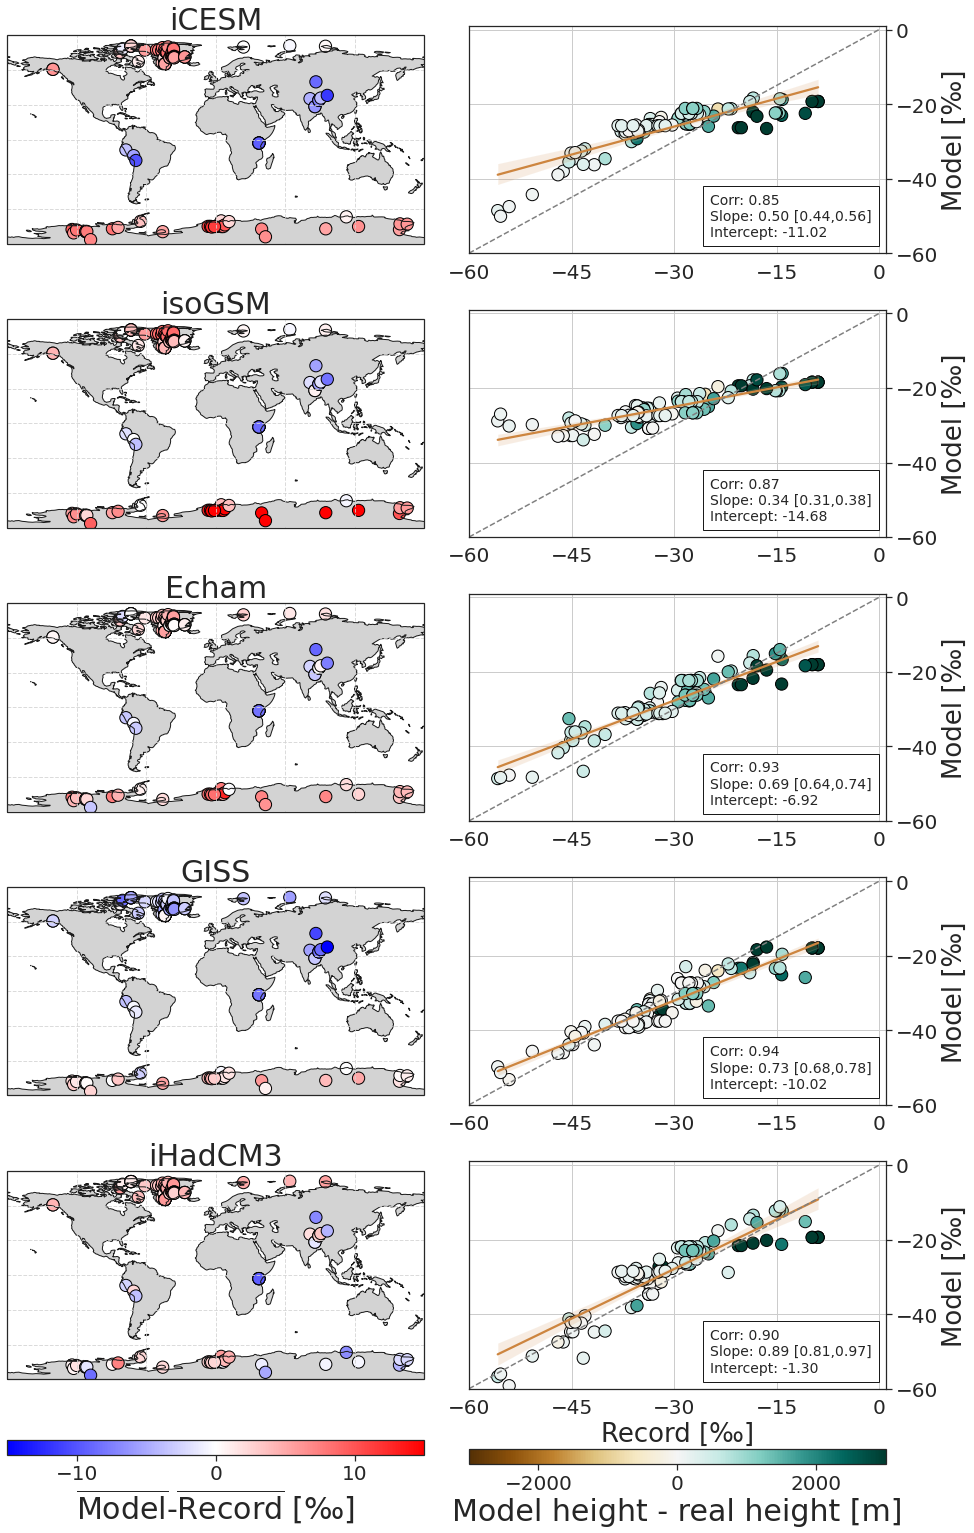

In [28]:
iso_plot=map_plot_vert(pp_y_all[1],iso2k_,names=list(oro_dic.keys()),title='',loc='lower right',vmin=-15,vmax=15,savefig=None,minval=-60)

In [29]:
iso_plot.savefig('/home/mchoblet/plots_thesis/5_1/iso_appendix.pdf', dpi='figure', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )

# Median of models and proxy records plot

- Hacky way in order to add the text boxes correctly.
- pack the previously generated psm converted data into vectors and only use first 1000 years.

In [31]:
# load all model, psm converted data into vectors
sisal_vec = []
iso2k_vec = []

for i,p in enumerate(sisal_):
    sisal_vec.append(sisal_[i].isel(time=slice(0,1000)).values)
    iso2k_vec.append(iso2k_[i].isel(time=slice(0,1000)).values)
    

In [32]:
#the proxy median (slice in time for excluding warming)
iso_proxy_m=pp_y_all[1].sel(time=slice('0850','1850')).median('time').values
sisal_proxy_m=pp_y_all[0].sel(time=slice('0850','1850')).median('time').values

#the interquartile range of model values
iqr_iso=iqr(np.concatenate(iso2k_vec,axis=0),axis=0)
iqr_sisal=iqr(np.concatenate(sisal_vec,axis=0),axis=0)

#the median values from the model
sisal_model_m=np.median(np.array(sisal_vec),axis=1)
iso_model_m=np.median(np.array(iso2k_vec),axis=1)

#the median values from all models
sisal_model_all=np.median(np.array(sisal_vec),axis=(0,1))
iso_model_all=np.median(np.array(iso2k_vec),axis=(0,1))

sisal_lat=pp_y_all[0].lat
sisal_lon=pp_y_all[0].lon

iso2k_lat=pp_y_all[1].lat
iso2k_lon=pp_y_all[1].lon

#join
model_all=[sisal_model_all,iso_model_all]
model_m=[sisal_model_m,iso_model_m]

proxy_m=[sisal_proxy_m,iso_proxy_m]
iqr_=[iqr_sisal,iqr_iso]

lons=[sisal_lon,iso2k_lon]
lats=[sisal_lat,iso2k_lat]

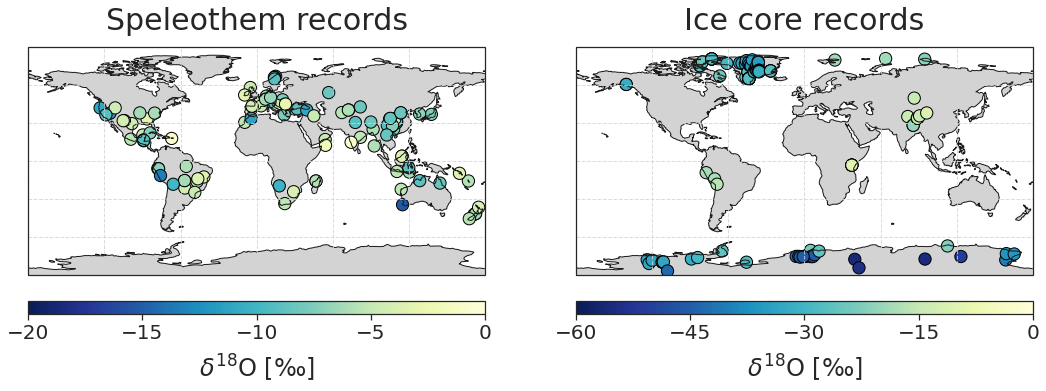

In [33]:
fig = plt.figure(figsize=(18,18))
gs = fig.add_gridspec(1, 2)

proxies=[sisal_proxy_m,iso_proxy_m]

cm=mpl.cm.get_cmap('YlGnBu_r')
mpl.rcParams.update({'font.size': 22})

label_size = 16
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

#first plot
ax0 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
ax0.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax0.coastlines(resolution='auto', color='k')
ax0.gridlines(color='lightgrey', linestyle='--', alpha=0.8,draw_labels=False,)

ax0.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
p0=ax0.scatter(lons[0],lats[0],c=proxies[0],s=150, cmap=cm, transform=ccrs.PlateCarree(), edgecolors='black',vmin=-20,vmax=0)

#second plot
ax1 = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree())
ax1.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax1.coastlines(resolution='auto', color='k')
ax1.gridlines(color='lightgrey', linestyle='--', alpha=0.8,draw_labels=False,)

ax1.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
p1=ax1.scatter(lons[1],lats[1],c=proxies[1],s=150, cmap=cm, transform=ccrs.PlateCarree(), edgecolors='black',vmin=-60,vmax=0)

#colorbars
pos0 = ax0.get_position().get_points().flatten()
#p2 = ax0.get_position().get_points().flatten()
    
ax_cbar1 = fig.add_axes([pos0[0],pos0[1]-0.03, pos0[2]-pos0[0],0.01])
cb=fig.colorbar(p0, cax=ax_cbar1, orientation='horizontal',cmap=cm,)
cb.set_label('$\delta^{18}$O [‰]',fontsize=24,labelpad=10)
cb.ax.tick_params(labelsize=20)
tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator
cb.update_ticks()

#colorbar 2
pos1 = ax1.get_position().get_points().flatten()

ax_cbar1 = fig.add_axes([pos1[0],pos1[1]-0.03, pos1[2]-pos1[0],0.01])
cb=fig.colorbar(p1, cax=ax_cbar1, orientation='horizontal',cmap=cm,)
cb.set_label('$\delta^{18}$O [‰]',fontsize=24,labelpad=10)
cb.ax.tick_params(labelsize=20)
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()


ax0.set_title('Speleothem records', y=1.05, fontsize=30, weight='normal')        
ax1.set_title('Ice core records', y=1.05, fontsize=30, weight='normal')

fig_median=fig

In [34]:
fig_median.savefig('/home/mchoblet/plots_thesis/5_1/proxy_medians.pdf', dpi='figure', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )

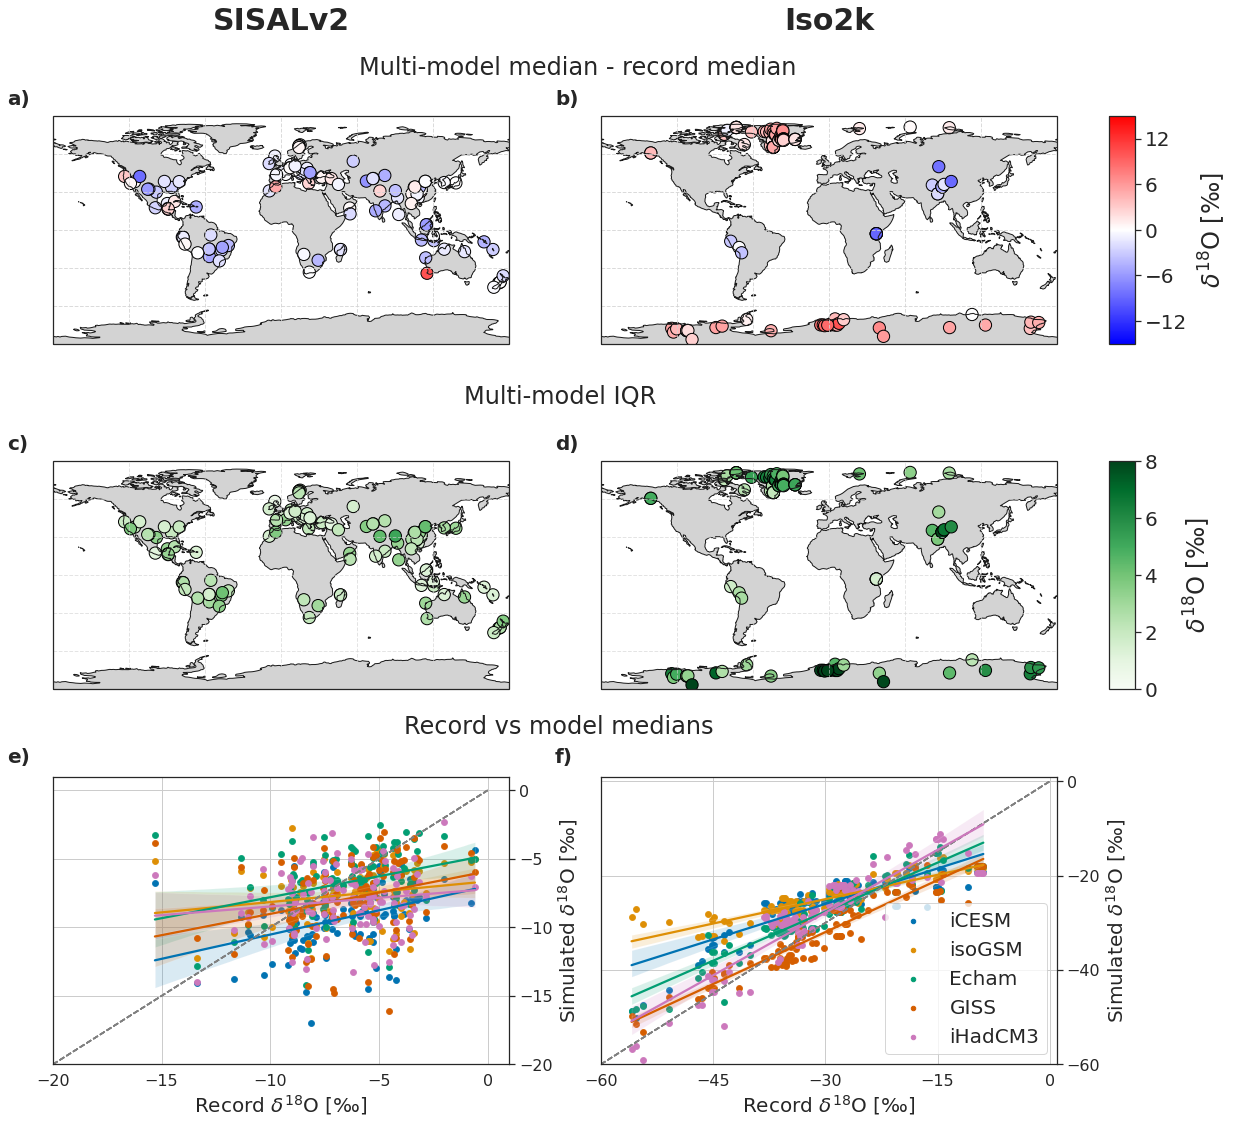

In [35]:
title='Comparison of model values and proxy record median'
names=list(oro_dic.keys())

#colorbars for interquartile range and me
vmin=-15
vmax=15

sns.set_theme(style="white")
fac=1.2
fig = plt.figure(figsize=(18,18))
gs = fig.add_gridspec(3, 2)

#colors for 5 different models (in the last column)
colors=(sns.color_palette(palette='colorblind', n_colors=5))
cm=mpl.cm.get_cmap('bwr')
mpl.rcParams.update({'font.size': 22})

label_size = 16
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

for i in range(2):
    #first plot: the multi model median - proxy median
    ax0 = fig.add_subplot(gs[0,i], projection=ccrs.PlateCarree())
    ax0.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
    ax0.coastlines(resolution='auto', color='k')
    ax0.gridlines(color='lightgrey', linestyle='--', alpha=0.8,draw_labels=False,)

    ax0.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
    p0=ax0.scatter(lons[i],lats[i],c=(model_all[i]-proxy_m[i]),s=150, cmap=cm, transform=ccrs.PlateCarree(), edgecolors='black',vmin=vmin,vmax=vmax)
    
    if i==0:
        st='a)'
        ax0.text(0.67, 1.18, 'Multi-model median - record median', transform=ax0.transAxes, 
            size=24)
        
    else:
        st='b)'
    ax0.text(-0.1, 1.05, st, transform=ax0.transAxes, 
            size=20, weight='bold')
    
    #second plot: the multi model median - proxy median
    ax1 = fig.add_subplot(gs[1,i], projection=ccrs.PlateCarree())
    ax1.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
    ax1.coastlines(resolution='auto', color='k')
    ax1.gridlines(color='lightgrey', linestyle='--', alpha=0.6,draw_labels=False,)

    ax1.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
    p1=ax1.scatter(lons[i],lats[i],c=iqr_[i],s=150, cmap='Greens', transform=ccrs.PlateCarree(), edgecolors='black',vmin=0,vmax=8)
    
    if i==0:
        st='c)'
        ax1.text(0.9, 1.25, 'Multi-model IQR', transform=ax1.transAxes, 
            size=24)
    else:
        st='d)'
    
    ax1.text(-0.1, 1.05, st, transform=ax1.transAxes, 
            size=20, weight='bold')
    
    if i==0:
        title_2='SISALv2'
    else:
        title_2='Iso2k'
    ax0.set_title(title_2, y=1.35, fontsize=30, weight='bold')
    
    ax2 = fig.add_subplot(gs[2,i])
    for j,n in enumerate(names):
        #ax2.plot(mean_proxy, mymodel,color='blue',ls='-',label=string)
        #p=axs[x].scatter(mean_proxy,mean_prior,c=z,s=150,cmap=cm, edgecolors='black',vmin=vmin,vmax=vmax)
        p2=ax2.scatter(proxy_m[i],model_m[i][j],color=colors[j],s=20,label=n)#,vmin=vmin,vmax=vmax)
        #ax2.set_title(names[x],fontsize=30)
        #axs[x].set_xlabel('proxy',fontsize=30)
        if i==0:
            minval=-20
        if i==1:
            minval=-60

        ax2.set_xlim((minval,1))
        ax2.set_ylim((minval,1))

        #set number of ticks
        ax2.locator_params(axis='y', nbins=5)
        ax2.locator_params(axis='x', nbins=3)
        ax2.plot(np.arange(minval,1,1),np.arange(minval,1,1),color='grey',ls='--')
        ax2.grid()
        ax2.yaxis.tick_right()
        #if x==2:
            #ax2.set_ylabel('Simulation after PSM',fontsize=30)
        #plt.gca().set_ylabel('Simulation', rotation=270, va="bottom",fontsize=30,labelpad=35)
        ax2.yaxis.set_label_position("right")
        #axs[x].yaxis.set_ticklabels([-20,-15,-10,-5,0])
        #if x!=4:
        #    ax2.set_xticks([])
        ax2.set_xticks(np.linspace(minval,0,5),fontsize=30)
        
        #plot regression lines with confidence intervals, cf=95%. Super easy with seaborn
        regplot(x=proxy_m[i],y=model_m[i][j],color=colors[j],ax=ax2,marker=None)
        
    if i==1:
        ax2.legend(loc='lower right',fontsize=20)
    ax2.set_xlabel(r'Record $\delta^{18}$O [‰]',fontsize=20)
    ax2.set_ylabel(r'Simulated $\delta^{18}$O [‰]',fontsize=20,x=1.2)
    
    if i==0:
        st='e)'
        ax2.text(0.77, 1.15, 'Record vs model medians', transform=ax2.transAxes, 
            size=24)
    else:
        st='f)'
    ax2.text(-0.1, 1.05, st, transform=ax2.transAxes, 
            size=20, weight='bold')
    
    """
    slope, intercept, r, p, std_err = stats.linregress(proxy_m[i],model_m[i][j])
    def myfunc(slope,x,intercept):
        return slope * x + intercept

    mymodel = myfunc(slope,proxy_m[i],intercept)
    mymodel_low=myfunc(slope+1.96*std_err,proxy_m[i],intercept)
    mymodel_high=myfunc(slope-1.96*std_err,proxy_m[i],intercept)
    """
    
from matplotlib import ticker

pos0 = ax0.get_position().get_points().flatten()
#p2 = ax0.get_position().get_points().flatten()
    
ax_cbar1 = fig.add_axes([pos0[2] +0.04, pos0[1], 0.02, pos0[3]-pos0[1]])
cb=fig.colorbar(p0, cax=ax_cbar1, orientation='vertical',cmap=cm,)
cb.set_label('$\delta^{18}$O [‰]',fontsize=24,labelpad=10)
cb.ax.tick_params(labelsize=20)
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()


pos0 = ax1.get_position().get_points().flatten()
#p2 = ax0.get_position().get_points().flatten()
    
ax_cbar1 = fig.add_axes([pos0[2] +0.04, pos0[1], 0.02, pos0[3]-pos0[1]])
cb=fig.colorbar(p1, cax=ax_cbar1, orientation='vertical',cmap=cm)
cb.ax.tick_params(labelsize=20)
cb.set_label('$\delta^{18}$O [‰]',fontsize=24,labelpad=25)
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()

fig_comparison=fig

In [36]:
fig_comparison.savefig('/home/mchoblet/plots_thesis/5_1/model_data_comparison.pdf', dpi='figure', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )

In [ ]:
#save if result satisfactory

#